In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
import shutil

def createIfNotExist(path):
    isExist = os.path.exists(path)
    if not isExist:
      os.makedirs(path)
      print(f"The new directory {path} is created!")

In [10]:
from PIL import Image
import os


def preprocess_image(input_path, output_path, shape=512, pref=''):
    output_name = pref
    paths_to_images = []
    image = Image.open(input_path)
    image = image.resize((shape, shape))
    image.save(output_path)
    paths_to_images.append(output_path + output_name + ".jpg")
    return paths_to_images


def preprocess_all_images_int_file_tree(input_path, output_path):
    cnt = 0
    for root, dirs, files in os.walk(input_path):
        for dir_name in dirs:
            if not os.path.exists(os.path.join(output_path, dir_name)):
                os.mkdir(os.path.join(output_path, dir_name))
        for file in os.listdir(root):
            if os.path.join(root, file).split('.')[-1] != 'jpg':
                cnt += 1
                continue
            cnt += 1
    with tqdm(total=cnt) as pbar:
        for root, dirs, files in os.walk(input_path):
            for file in os.listdir(root):
                if os.path.join(root, file).split('.')[-1] != 'jpg':
                    pbar.update(1)
                    continue
                curr_out_path = os.path.join(os.path.join(output_path + root.split('/')[-1]),file)
                preprocess_image(os.path.join(root, file), curr_out_path)
                pbar.update(1)

input_dataset_path = "raw_data/"
reduced_output_dataset_path = "reduced_data/"

createIfNotExist(reduced_output_dataset_path)

preprocess_all_images_int_file_tree(input_dataset_path, reduced_output_dataset_path)

The new directory reduced_data/ is created!


100%|██████████| 479/479 [02:15<00:00,  3.54it/s]


In [11]:
folders = [name for name in os.listdir(reduced_output_dataset_path) if os.path.isdir(os.path.join(os.getcwd(), reduced_output_dataset_path, name))]
folders, len(folders)

(['Coworking',
  'Двери в туалет',
  'Проход к столовой',
  'Вход в арену',
  'Nagano',
  'Лестница у входа',
  'Milan ',
  'Спортивный комплекс внутри арены',
  'Cafeteria',
  'Sochi',
  'Лестница около коворкинга'],
 11)

In [12]:
train_prob = 0.8
test_prob = 0.1
val_prob = 0.1
random_state = 228 
np.random.seed(random_state)

train = []
test = []
val = []
all_data = []

for folder in folders:
    files = os.listdir(os.path.join(os.getcwd(), reduced_output_dataset_path, folder))
    if '.DS_Store' in files:
        files.remove('.DS_Store')
    np.random.shuffle(files)
    train_ind = int(len(files) * train_prob)
    test_ind = int(len(files) * (train_prob + test_prob))
    train.append((files[:train_ind], folder))
    test.append((files[train_ind:test_ind], folder))
    val.append((files[test_ind:], folder))
    all_data.append((files, folder))

In [13]:
result_folder = "airi_dataset"

In [14]:
import json

metainfo = {'num_to_class': {i:name for i, name in enumerate(folders)},
            'data': {'train_size': len(train),
                    'test_size': len(test),
                    'val_size': len(val)
                    }
            }

with open(f"{result_folder}/metainfo.json", "w") as fout:
    json.dump(metainfo, fout)

In [15]:
createIfNotExist(result_folder)

def process_subset(files, subset_name):
    for files_arr, folder in files:
        curDir = os.path.join(os.getcwd(), result_folder, subset_name, folder)
        createIfNotExist(curDir)
        for file in files_arr:
            srcFile = os.path.join(os.getcwd(), reduced_output_dataset_path, folder, file)
            print(srcFile)
            dstFile = os.path.join(os.getcwd(), result_folder, subset_name, folder, file)
            shutil.copyfile(srcFile, dstFile)

In [18]:
process_subset(train, 'train')
process_subset(test, 'test')
process_subset(val, 'val')

/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Coworking/IMG_20220706_184153.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Coworking/IMG_20220706_184144.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Coworking/IMG_20220706_184215.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Coworking/IMG_20220706_184241(1).jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Coworking/IMG_20220706_184149_1.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Coworking/IMG_20220706_184301.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Coworking/IMG_20220706_184150.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/NetVLADApproach/reduced_data/Coworking/IMG_20220706_184303_1.jpg
/Users/garipovroma/work/airi-school/AIRISchoolProject/Net

In [16]:
class_count = [len(samples) for (samples, class_name) in all_data]
classes = [class_name for (samples, class_name) in all_data]
class_count

[49, 12, 55, 70, 82, 26, 35, 10, 10, 78, 29]

<BarContainer object of 11 artists>

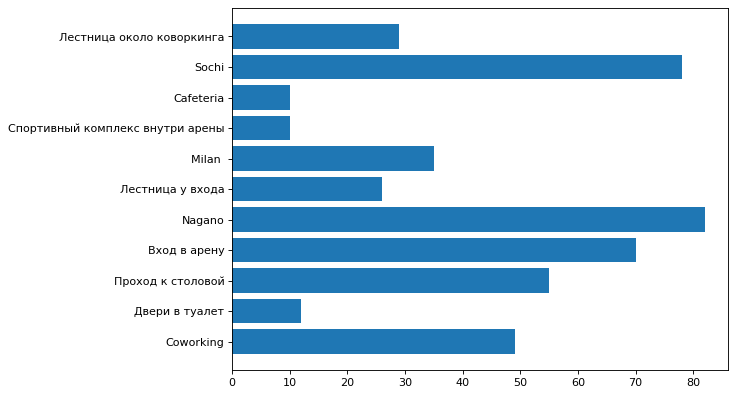

In [17]:
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(classes, width=class_count)